# Classification of TikTok Videos - Machine Learning Project

## Overview
The main objective of this project is to develop a machine learning model to predict whether videos reported by users presented claims or opinions to improve triaging process of videos for further review by human moderators.

## Project Outline
1. [Project Background](#project_background)
2. [About The Dataset](#about_the_dataset)
3. [Importing Libraries](#importing_libraries)
4. [Preliminary Data Inspection](#preliminary_data_inspection)
5. [Data Cleaning](#data_cleaning)
6. [Exploratory Data Analysis](#exploratory_data_analysis)
7. [Statistical Testing](#statistical_testing)
8. [Machine Learning Model Development](#machine_learning_model_development)
9. [Discussion](#discussion)
10. [Conclusion](#conclusion)
11. [Appendix](#appendix)

## Project Background
<a id='project_background'></a>

TikTok is the leading social platform for short-form videos.  TikTok users can report videos and comments containing user claims. These reported videos may contain content that violates the company’s terms of use policy and needs to be reiewed by human moderators. The successful development of a predictive model will help reduce the backlog of user reports and process them more efficiently.

## About The Dataset
<a id='about_the_dataset'></a>

The dataset contains user reported videos which are classified as claims or opinions. Each video data contains 12 attributes with their definitions listed in the table below.

***DISCLAIMER:** This dataset is synthetically prepared by Google in partnership with TikTok as end-of-course project material for the Google Advanced Data Analytics Professional Certificate on Coursera.*

| Column name | Type | Description |
| ----------- | ---- | ----------- |
| # | int | TikTok assigned number for video with claim/opinion. |
| claim_status | obj | Whether the published video has been identified as an “opinion” or a “claim.” In this dataset, an “opinion” refers to an individual’s or group’s personal belief or thought. A “claim” refers to information that is either unsourced or from an unverified source. |
| video_id | int | Random identifying number assigned to video upon publication on TikTok. |
| video_duration_sec | int | How long the published video is measured in seconds. |
| video_transcription_text | obj | Transcribed text of the words spoken in the published video. |
| verified_status | obj | Indicates the status of the TikTok user who published the video in terms of their verification, either “verified” or “not verified.” |
| author_ban_status | obj | Indicates the status of the TikTok user who published the video in terms of their permissions: “active,” “under scrutiny,” or “banned.” |
| video_view_count | float | The total number of times the published video has been viewed. |
| video_like_count | float | The total number of times the published video has been liked by other users. |
| video_share_count | float | The total number of times the published video has been shared by other users. |
| video_download_count | float | The total number of times the published video has been downloaded by other users. |
| video_comment_count | float | The total number of comments on the published video. |

## Importing Libraries
<a id='importing_libraries'></a>

In [1]:
# Import operational packages.
import pandas as pd
import numpy as np

# Import data visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns

# Import Plotly for creating data visualizations for publication.
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go  

# Import statistical analysis packages.
from statsmodels.stats.proportion import proportions_ztest

# Import machine learning model development packages.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Import package for saving and loading machine learning models.
import pickle

## Preliminary Data Inspection
<a id='preliminary_data_inspection'></a>

Load the dataset into a DataFrame.

In [2]:
# Load dataset into a pandas dataframe.
data = pd.read_csv('./data/tiktok_dataset.csv')

In [3]:
# Examine first 5 rows of the dataset.
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Display general information about the dataset using `.info()` and `describe()`.

In [4]:
# Display general summary of the dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


**NOTE:**

Some columns contain null values which needs to be inspected and handled later.

In [5]:
# Calculate descriptive statistics of numeric variables in the dataset.
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


**NOTE:**

Video engagement attributes `video_view_count`, `video_like_count`, `video_share_count`, `video_download_count`, and `video_comment_count` have maximum values that are much larger than their respective third quartiles, suggesting presence of outliers.

Examine class balance of the target variable `claim_status`.

In [6]:
# Examine class balance of `claim_status`.
claim_status_counts = data['claim_status'].value_counts()
claim_status_counts

claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

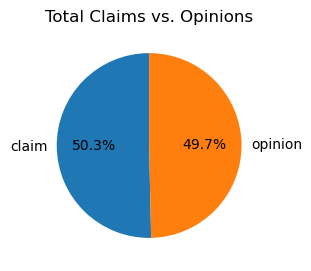

In [7]:
# Create pie chart of `claim_status` share.
plt.figure(figsize=(3,3))
plt.pie(claim_status_counts, labels=claim_status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Total Claims vs. Opinions')
plt.show()

**NOTE:**

The dataset contains 50.3% claim videos and 49.7% opinion videos. The dataset is balanced - claim and opinion videos are equally represented. No unexpected values of `claim_status` were observed.

Examine values of categorical variables `verified_status` and `author_ban_status`.

In [8]:
# Examine unique values of `verified_status`.
data['verified_status'].unique()

array(['not verified', 'verified'], dtype=object)

In [9]:
# Examine unique values of `author_ban_status`.
data['author_ban_status'].unique()

array(['under review', 'active', 'banned'], dtype=object)

**NOTE:**

No unecxpected values were observed in `verified_status` and `author_ban_status`.

### Results

The dataset contains sufficient data to proceed with the project. Below is the summary of the key insights gathered from this section:
1. The dataset contains 19382 entries with 12 attributes. There are several attributes with missing data.
2. There are potential outliers in the video engagement  attributes (views, like, etc.) taht need to be further investigated.
3. Claim and opinion videos are equally represented in the dataset. This removes the problem of bias towards one video content type.

## Data Cleaning
<a id='data_cleaning'></a>

Check and handle missing data.

In [10]:
# Count the number of missing values for each column.
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

**NOTE:**

The main goal of the project is to classify video as claim or opinion, so videos with missing `claim_status` data do not add any value to the project. Therefore these rows will be removed.

In [11]:
# Create backup of original data.
data_copy = data.copy()

In [12]:
# Remove data with missing `claim_status`.
data.dropna(subset=['claim_status'], axis=0, inplace=True)

# Recheck for missing values.
data.isna().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

Check and handle duplicate values.

In [13]:
# Display number of duplicate rows.
data.duplicated().sum()

0

**NOTE:**

The dataset contains no duplicate values.

### Results

A total of 298 rows with missing `claim_sattus` values were removed from the dataset. The resulting dataset is clean and contains no missing and duplicate data.

## Exploratory Data Analysis
<a id='exploratory_data_analysis'></a>

### Distribution of Numeric Variables

Create box plot and histogram for each numeric variable to examine distribution.

#### `video_duration_sec`

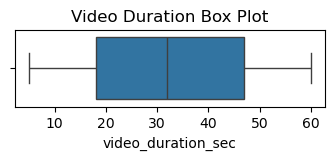

In [14]:
# Create box plot of `video_duration_sec`.
plt.figure(figsize=(4,1))
sns.boxplot(data, x='video_duration_sec')
plt.title('Video Duration Box Plot')
plt.show()

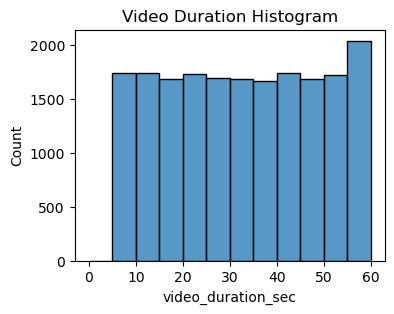

In [15]:
# Create histogram of `video_duration_sec`.
plt.figure(figsize=(4,3))
sns.histplot(data, x='video_duration_sec', bins=12, binrange=(0, 60))
plt.title('Video Duration Histogram')
plt.show()

**NOTE:**

Duration of videos are more or less evenly distributed across the range. There are also no outliers in the variable.

#### `video_view_count`

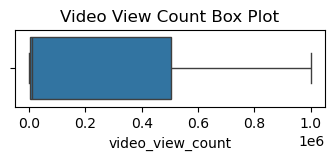

In [16]:
# Create box plot of `video_view_count`.
plt.figure(figsize=(4,1))
sns.boxplot(data, x='video_view_count')
plt.title('Video View Count Box Plot')
plt.show()

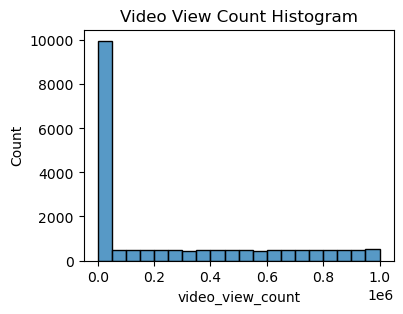

In [17]:
# Create histogram of `video_view_count`.
plt.figure(figsize=(4,3))
sns.histplot(data, x='video_view_count', bins=20)
plt.title('Video View Count Histogram')
plt.show()

**NOTE:**

Majority of the videos have less than 50,000 views. Videos having more than 50,000 views are evenly distributed across the range. No outliers were observed in the variable.

#### `video_like_count`

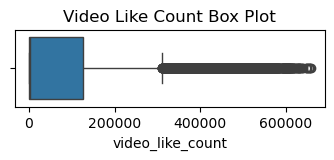

In [18]:
# Create box plot of `video_like_count`.
plt.figure(figsize=(4,1))
sns.boxplot(data, x='video_like_count')
plt.title('Video Like Count Box Plot')
plt.show()

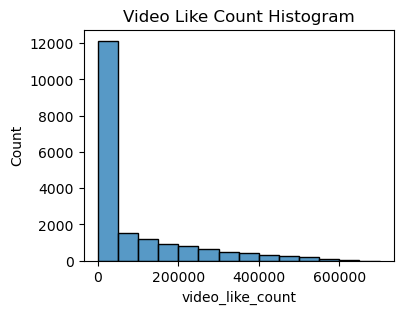

In [19]:
# Create histogram of `video_like_count`.
plt.figure(figsize=(4,3))
sns.histplot(data, x='video_like_count', bins=14, binrange=(0, 700000))
plt.title('Video Like Count Histogram')
plt.show()

**NOTE:**

Majority of the videos have less than 50,000 likes. The distribution of data is heavily skewed to the right with several outliers identified on the box plot.

#### `video_share_count`

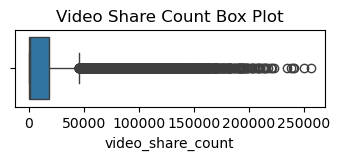

In [20]:
# Create box plot of `video_share_count`.
plt.figure(figsize=(4,1))
sns.boxplot(data, x='video_share_count')
plt.title('Video Share Count Box Plot')
plt.show()

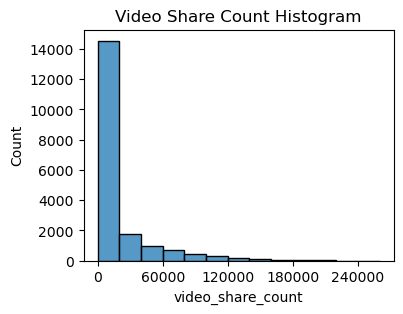

In [21]:
# Create histogram of `video_share_count`.
plt.figure(figsize=(4,3))
sns.histplot(data, x='video_share_count', bins=13, binrange=(0, 260000))
plt.title('Video Share Count Histogram')
plt.xticks(range(0, 260000, 60000))
plt.show()

**NOTE:**

Majority of the videos have less than 20,000 shares. The distribution of data is heavily skewed to the right with several outliers identified in the box plot.

#### `video_download_count`

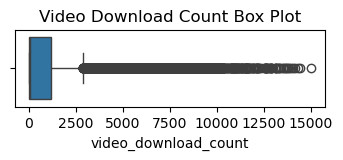

In [22]:
# Create box plot of `video_download_count`.
plt.figure(figsize=(4,1))
sns.boxplot(data, x='video_download_count')
plt.title('Video Download Count Box Plot')
plt.show()

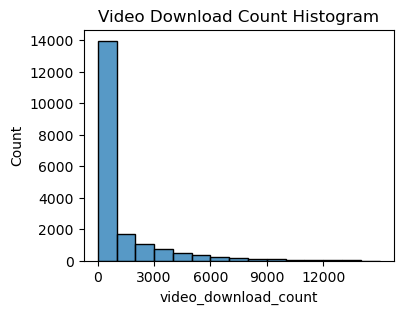

In [23]:
# Create histogram of `video_download_count`..
plt.figure(figsize=(4,3))
sns.histplot(data, x='video_download_count', bins=15, binrange=(0, 15000))
plt.title('Video Download Count Histogram')
plt.xticks(range(0, 15000, 3000))
plt.show()

**NOTE:**

Majority of the videos have less than 1,000 downloads. The distribution of data is heavily skewed to the right with several outliers identified in the box plot.

#### `video_comment_count`

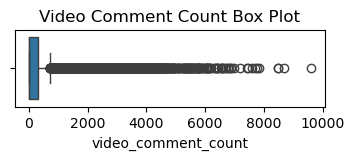

In [24]:
# Create box plot of `video_comment_count`.
plt.figure(figsize=(4,1))
sns.boxplot(data, x='video_comment_count')
plt.title('Video Comment Count Box Plot')
plt.show()

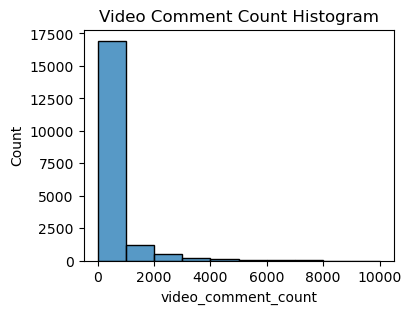

In [25]:
# Create histogram of `video_comment_count`.
plt.figure(figsize=(4,3))
sns.histplot(data, x='video_comment_count', bins=10, binrange=(0, 10000))
plt.title('Video Comment Count Histogram')
plt.show()

**NOTE:**

Majority of the videos have less than 1,000 comments. The distribution of data is heavily skewed to the right with several outliers identified in the box plot.

### Distribution of Categorical Variables

#### `claim_status`

Examine distribution of numeric variables by `claim_status`.

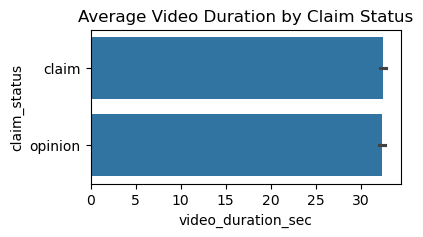

In [26]:
# Compare average video duration by `claim_status`
plt.figure(figsize=(4,2))
sns.barplot(data, x='video_duration_sec', y='claim_status', estimator='mean', orient='horizontal')
plt.title('Average Video Duration by Claim Status')
plt.show()

**NOTE:**

Average video duration for both claim and opinion videos are very similar.

In [27]:
# Create list of video engagement attributes.
video_engagement = ['video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count']

# Calculate median video engagement measures by `claim_status`.
engagement_by_claim = data.groupby('claim_status')[video_engagement].median().reset_index()
engagement_by_claim

,claim_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,claim,501555.0,123649.0,17997.5,1139.5,286.0
1,opinion,4953.0,823.0,121.0,7.0,1.0


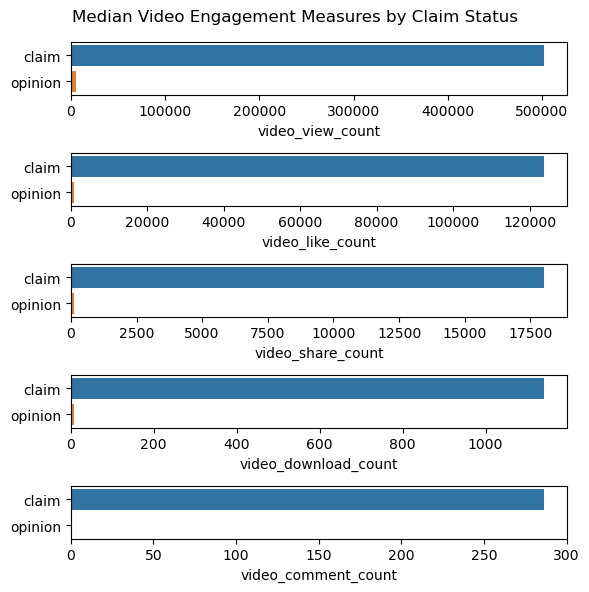

In [28]:
# Plot video engagement attributes by `claim_status`.

# Create 5x1 subplots.
fig, axs = plt.subplots(5, 1, figsize=(6,6))

# Iterate through and create bar plot by `claim_status` for each video engagement attribute.
for i, column in enumerate(video_engagement):
    sns.barplot(engagement_by_claim, x=column, ax=axs[i], y='claim_status', hue='claim_status')
    axs[i].set_ylabel('')  # Remove y-axis label.

plt.suptitle('Median Video Engagement Measures by Claim Status')
plt.tight_layout()
plt.show()

**NOTE:**

Claim videos have median video engagement attributes much higher than opinion videos. These variables may be strong predictors of `claim_status`. Note that median was chosen as a measure of central tendency as it is less sensitive to outliers.

#### `verified_status` by `claim_status`

In [29]:
# Display value counts of `verified_status` grouped by `claim_status`.
data.groupby('verified_status')['claim_status'].value_counts()

verified_status  claim_status
not verified     claim           9399
                 opinion         8485
verified         opinion          991
                 claim            209
Name: count, dtype: int64

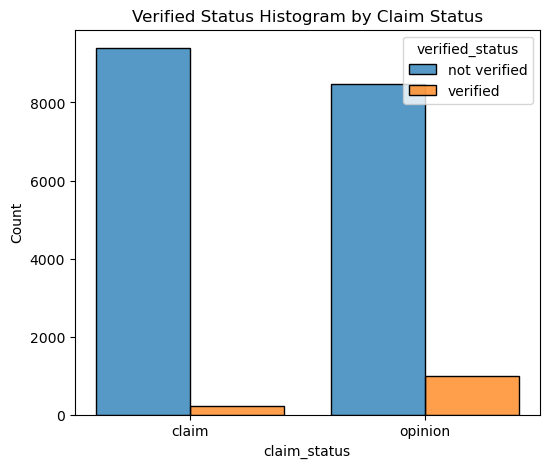

In [30]:
# Create `verified_status` histogram grouped by `claim_status`.
plt.figure(figsize=(6,5))
ax = sns.histplot(data, x='claim_status', hue='verified_status', multiple='dodge', shrink=0.8)
plt.title('Verified Status Histogram by Claim Status')
plt.show()

**NOTE:**

There are more videos from unverified accounts than verified accounts regardless of claim status, but there are more opinion videos from verified accounts than claim videos. This suggests verified accounts are more likely to post opinion videos.

#### `author_ban_status` by`claim_status`

In [31]:
# Display value counts of `author_ban_status` grouped by `claim_status`.
data.groupby('author_ban_status')['claim_status'].value_counts()

author_ban_status  claim_status
active             opinion         8817
                   claim           6566
banned             claim           1439
                   opinion          196
under review       claim           1603
                   opinion          463
Name: count, dtype: int64

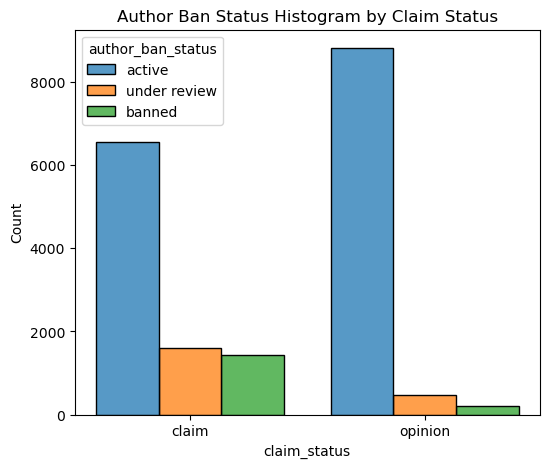

In [32]:
# Create `author_ban_status` histogram grouped by `claim_status`.

# Create list to set order of `author_ban_status` groups in the bar plot.
group_order = ['active', 'under review', 'banned']

plt.figure(figsize=(6,5))
ax = sns.histplot(data, x='claim_status', hue='author_ban_status', hue_order=group_order, multiple='dodge', shrink=0.8)
plt.title('Author Ban Status Histogram by Claim Status')
plt.show()

**NOTE:**

There are more videos from active authors compared to banned authors regardless of claim status. Claim videos have a larger percentage of banned authors and authors under review compared to opinion videos, suggesting that authors that post claim videos are more likely to be under review or get banned. This observation suggests that claim videos are more likely to have content that violates TikTok's terms of use policy. It should be noted that there is no provideed information on whether the specific reported videeo caused the authors to be banned or brought under review. There is also no information if videos are posted by the same author.

#### Video engagement by `verified_status`

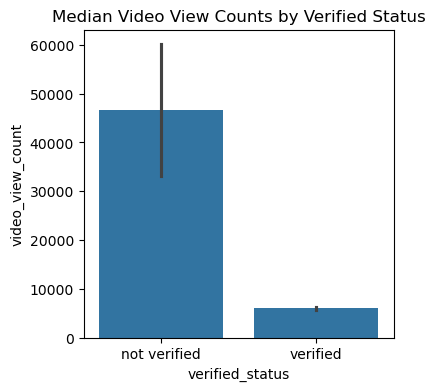

In [33]:
# Compare median view counts by `verified_status`
plt.figure(figsize=(4,4))
sns.barplot(data, x='verified_status', y='video_view_count', estimator='median')
plt.title('Median Video View Counts by Verified Status')
plt.show()

**NOTE:**

Videos posted by unverified accounts have higher video engagement.

#### Video Engagement by `author_ban_status`

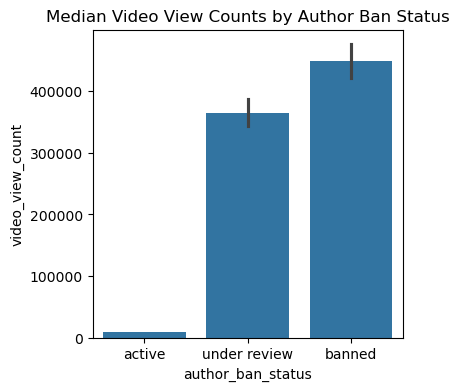

In [34]:
# Compare median view counts by `author_ban_status`
plt.figure(figsize=(4,4))
sns.barplot(data, x='author_ban_status', y='video_view_count', estimator='median', order=['active', 'under review', 'banned'])
plt.title('Median Video View Counts by Author Ban Status')
plt.show()

**NOTE:**

Videos from banned authors and authors under review have higher video view counts than active authors. This agrees with the observed trend of claim videos having higher engagement and more shares of banned authors and authors under review.

### Results

1. Claim videos have higher video enaggement (`video_view_count`, `video_like_count`, `video_share_count`, `video_download_count`, `cideo_comment_count`). These variables may be strong predictors of `claim_status`.
2. Verified accounts seem more likely to post opinion videos. Further analysis of the observed difference in behavior is statistically significant.
3. Authors that post claim videos are more likely to get banned, suggesting claim videos are more likely to violate TikTok's terms of use policy.

## Statistical Testing
<a id='statistical_testing'></a>

Previous analysis showed that verified accounts tend to post more opinion videos. A statistical test will be conducted to verify its statistical signifiance.

Specifically, a z-test of two sample proportions will be conducted with a significance level of 0.05 to test whether there is a statistically significant difference in the proportion of claim videos between verified and unverified users.
* Null hypothesis: There is no significant difference in the proportion of claim videos between unverified and verified users.
* Alternative hypothesis: There is a significant difference in the proportion of claim videos between unverified and verified users.

In [35]:
# Set signifcance level.
significance_level = 0.05

# Create array of number of claim videos by `verified_status`.
claim_counts = data[data['claim_status']=='claim']['verified_status'].value_counts()
print('Value counts of claim videos')
print(claim_counts)
print('\n')

# Create array of total number of videos by `verified_status`.
total_counts = data['verified_status'].value_counts()
print('Total video counts')
print(total_counts)
print('\n')

# Conduct z-test of two sample proportions.
zstat, pvalue = proportions_ztest(count=claim_counts, nobs=total_counts)
print(f'p-value = {pvalue}')
print(f'significance_level = {significance_level}')
print(f'{pvalue} < {significance_level} == {pvalue < significance_level}')

Value counts of claim videos
verified_status
not verified    9399
verified         209
Name: count, dtype: int64


Total video counts
verified_status
not verified    17884
verified         1200
Name: count, dtype: int64


p-value = 8.298766149193901e-123
significance_level = 0.05
8.298766149193901e-123 < 0.05 == True


### Results

The calculated p-value is less than the significance level of 0.05. Therefore, the null hypothesis is rejected; there is a significant difference in the proportion of claim videos posted by verified accounts vs unverified accounts.

This result supports the observation that verified accounts are more likely to post opinion videos, therefore `verified_status` may be a predictor of `claim_status`.

## Machine Learning Model Development
<a id='machine_learning_model_development'></a>

The primary goal of the project is to build a machine learning model that classifies user reported videos as claims or opinions. Successful development of the predictive model will streamline the review process of reported videos by automating the intial steps of triaging videos.

This section will proceed in three main stages:
1. Ethical considerations
2. Feature engineering
3. Model building and evaluation

Since the outcome variable is binary categorical (`claim` or `opinion`), **Random Forest** and **XGBoost** classifiers will be used as machine learning models.

In order to develop a robust model, the dataset will be split 60/20/20 into training, validation, and test data. The training data will be used to build and tune the machine learning models through hyperparameter tuning with cross-validation. Performance of each model will then be compared using validation data to select a champion model. The champion model will then be evaluated using test data to simulate real-world performance.

### Ethical Considerations

While accurate predictions of the model will help streamline the triaging process of reported videos, false predictions will have consequences:
* **False positive predictions** - videos classified as claims but are actually opinion videos, will result in prioritizing the incorrect videos for further human review, reducing the overall efficiency of the review process.
* **False negative predictions** - videos classified as opinions but are actually claims, will result in the model failing to identify videos that need to be further reviewed. As observed in the EDA section, authors that post claim videos are more likely to get banned, suggesting claim videos are more likely to contain content that violate TikTok's terms of use policy.

False negative predictions pose a higher risk to the business than false positives. Therefore, the performance of the models will be evaluated using `recall_score`, which penalizes false negative predictions.

Overall, the benefits of building the model outweighs the potential problems.

### Preprocessing and Feature Engineering

First, recheck class balance of the outcome variable `claim_status`.

In [36]:
data['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

**NOTE:**

The classes are balanced, with both classes almost equally represented. Therefore there is no need for resampling or stratified sampling.

The models that will be used are resistant to outliers, so there is no need to impute outliers.

### Feature Engineering

#### Feature Selection

In [37]:
# Inspect data
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.9+ MB


The columns `#` and `video_id` are irrelevant to the model development, therefore these will b e excluded from the data. `video_transcription_text` is not readily useable, but useful features can be extracted from it.

In [38]:
# Drop irrelevant columns.
data.drop(['#', 'video_id'], axis=1, inplace=True)

#### Feature Transformation and Extraction

 Split data into feature and target variables.

In [39]:
# Create variable x for features.
x = data.drop('claim_status', axis=1)

# Create variable y for target.
y = data['claim_status']

In [40]:
# Inspect features.
x.head()

,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Convert categorical variables to numeric.

In [41]:
# Convert categorical features into numeric through one-hot encoding.
x = pd.get_dummies(x, drop_first=True, columns=['verified_status', 'author_ban_status'])

# Inspect transformed features.
x.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,False,False,False


In [42]:
# Create one-hot encoded variable for claim videos.
y = pd.get_dummies(y)['claim']

# Inspect target
y

0         True
1         True
2         True
3         True
4         True
         ...  
19079    False
19080    False
19081    False
19082    False
19083    False
Name: claim, Length: 19084, dtype: bool

Create feature for length of `video_transcription_text`

In [43]:
# Calculate transcription text length.
x['text_len'] = data['video_transcription_text'].apply(func=lambda text: len(text))

# Inspect features.
x.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,verified_status_verified,author_ban_status_banned,author_ban_status_under review,text_len
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,False,False,True,97
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,False,False,False,107
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,False,False,False,137
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,False,False,False,131
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,False,False,False,128


#### Split data into training/validation/test sets

In [44]:
# Split data into (training+validation) and test sets.
x_tr, x_test, y_tr, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Split (training+validation) into training and validation sets.
x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=0)

#### Vectorizing `video_transcription_text`

It is important to split training, validation, and test data first before vectorizing `video_transcription_text`. The `CountVectorizer` will be fitted with the training data only to avoid data leakage across training, validation, and test data.

In [45]:
# Create a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english'
                           )
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

Fit and transform training data.

In [46]:
# Get n-grams of transcription text of training data.
train_counts = count_vec.fit_transform(x_train['video_transcription_text']).toarray()

# Get feature names of the vectorized transcription text.
counts_features = count_vec.get_feature_names_out()

# Merge counts with training data.
train_counts_df = pd.DataFrame(train_counts, columns=counts_features)
x_train_final = pd.concat([x_train.drop('video_transcription_text', axis=1).reset_index(drop=True), train_counts_df], axis=1)

# Inspect new training data.
x_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,verified_status_verified,author_ban_status_banned,author_ban_status_under review,text_len,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,False,False,False,134,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,False,True,False,97,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,False,False,True,76,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,False,False,False,58,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,False,False,False,57,...,0,0,0,0,0,0,0,0,0,0


Transform validation data.

In [47]:
# Get n-grams of transcription text of validation data.
val_counts = count_vec.transform(x_val['video_transcription_text']).toarray()

# Merge counts with validation data.
val_counts_df = pd.DataFrame(val_counts, columns=counts_features)
x_val_final = pd.concat([x_val.drop('video_transcription_text', axis=1).reset_index(drop=True), val_counts_df], axis=1)

# Inspect validation data.
x_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,verified_status_verified,author_ban_status_banned,author_ban_status_under review,text_len,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,False,False,True,72,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,False,False,False,96,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,False,False,False,88,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,False,False,False,83,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,False,False,True,104,...,0,0,0,0,0,0,0,1,0,0


Transform test data.

In [48]:
# Get n-grams of transcription text of test data.
test_counts = count_vec.transform(x_test['video_transcription_text']).toarray()

# Merge counts with test data.
test_counts_df = pd.DataFrame(test_counts, columns=counts_features)
x_test_final = pd.concat([x_test.drop('video_transcription_text', axis=1).reset_index(drop=True), test_counts_df], axis=1)

# Inspect validation data.
x_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,verified_status_verified,author_ban_status_banned,author_ban_status_under review,text_len,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,False,False,False,107,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,True,False,True,69,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,False,False,False,90,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,False,False,False,76,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,False,False,False,72,...,0,0,0,0,0,0,0,0,0,0


### Model Building

#### Random Forest

Create a `RandomForestClassifier` object, construct `GridSearchCV` object, and set search grid for hyperparameter tuning.

In [49]:
# Create random forest object instance.
rf = RandomForestClassifier(random_state=0)

# Set search grid for hyperparameter tuning.
rf_cv_params = {'max_depth': [4, 8, None],
                'max_samples': [0.4, 0.5, 0.6, 0.7, 0.8],
                'max_features': [0.4, 0.5, 0.6, 0.7, 0.8],
                'min_samples_leaf': [1, 2],
                'min_samples_split': [2, 4],
                'n_estimators': [100, 150, 200, 250]
               }

# Create list of scoring metrics to calculate.
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Create GridSearchCV object instance for random forest.
rf_cv = GridSearchCV(estimator=rf, 
                     param_grid=rf_cv_params, 
                     scoring=scoring, 
                     cv=5,
                     refit='recall', 
                     n_jobs=-1
                    )

Fir data to train random forest model

In [50]:
%%time
# Uncomment to train model
#rf_cv.fit(x_train_final, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


Create functions to save and load the model object as `.pickle` file, so it can be used later without the need to retrain the model.

In [51]:
def save_model(model_object, file_name: str):
    """
    This function writes a machine learning model model_object into a .pickle file.
    """
    with open(f'{file_name}.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def load_model(file_name: str):
    """
    This function reads a .pickle file and returns a machine learning model object.
    """
    with open(f'{file_name}.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
        return model

Save/load the random forest model.

In [52]:
# Uncomment to save model to .pickle file
#save_model(model_object=rf_cv, file_name='rf_cv')

In [53]:
# Uncomment to load model from .pickle file
rf_cv = load_model(file_name='rf_cv')

Get score and parameters of best estimator

In [54]:
# Get recall score of best estimaor.
rf_cv.best_score_

0.9951682484900776

In [55]:
# Get parameters of best estimator.
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.7,
 'max_samples': 0.8,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 250}

#### XGBoost

Create a `XGBClassifier` object, construct `GridSearchCV` object, and set search grid for hyperparameter tuning.

In [56]:
# Create xgboost classifier object instance.
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Set search grid for hyperparameter tuning.
xgb_cv_params = {'max_depth': [4, 8, 12, None],
                 'min_child_weight': [2, 4, 6, 8],
                 'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
                 'n_estimators': [50, 100, 200, 300, 400, 500]
                }

# Create list of scoring metrics to calculate.
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Create GridSearchCV object instance for XGBoost.
xgb_cv = GridSearchCV(estimator=xgb,
                      param_grid=xgb_cv_params,
                      scoring=scoring,
                      cv=5,
                      refit='recall',
                      n_jobs=-1
                     )

Fir data to train XGBoost model

In [57]:
%%time
#xgb_cv.fit(x_train_final, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


Save/load the XGBoost model.

In [58]:
# Uncomment to save model to .pickle file
#save_model(model_object=xgb_cv, file_name='xgb_cv')

In [59]:
# Uncomment to load model from .pickle file
xgb_cv = load_model(file_name='xgb_cv')

Get score and parameters of best estimator.

In [60]:
# Get recall score of best estimaor.
xgb_cv.best_score_

0.991025704071612

In [61]:
# Get parameters of best estimator.
xgb_cv.best_params_

{'learning_rate': 0.001,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 50}

### Model Validation

The constructed random forest and XGBoost classifier models will be evaluated using validation data. The champion model will be the model with the highest recall score.

#### Random Forest

Create function to calculate performance scores of model.

In [62]:
def get_test_scores(model_name: str, y_true, y_pred):
    """
    This function calculates performance metrics and compiles them into a DataFrame.
    """
    table = pd.DataFrame({'model': [model_name],
                          'accuracy': [accuracy_score(y_true, y_pred)],
                          'precision': [precision_score(y_true, y_pred)],
                          'recall': [recall_score(y_true, y_pred)],
                          'f1': [f1_score(y_true, y_pred)]
                         }
                        )
    return table

Get prediction on validation data using random forest model and calculate performance metrics.

In [63]:
# Get predictions on validation data using random forest model.
rf_val_preds = rf_cv.predict(x_val_final)

In [64]:
# Get validation scores for random forest model.
rf_val_results = get_test_scores('Random Forest Validation', y_val, rf_val_preds)
rf_val_results

,model,accuracy,precision,recall,f1
0,Random Forest Validation,0.99738,0.997403,0.997403,0.997403


Plot confusion matrix of random forest results.

In [65]:
def plot_confusion_matrix(y_true, y_pred, chart_title: str = 'Confusion Matrix'):
    """
    This function creates a confusion matrix from actual value y_true and predicted value y_pred, 
    and sets specified chart title.
    """
    fig, ax = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['opinion', 'claim'], ax=ax)
    plt.title(chart_title)
    plt.show()

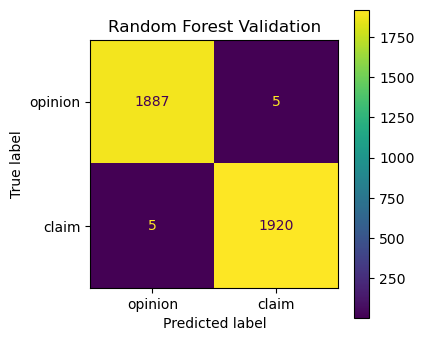

In [66]:
# Plot confusion matrix.
plot_confusion_matrix(y_val, rf_val_preds, chart_title='Random Forest Validation')

**NOTE:**

The random forest model has excellent performance on predicting the validation data. The same number of false positives and false negatives is observed in the confusion matrix, in agreement with the equal precision and recall score of the model.

#### XGBoost

Get predictions on validation data using XGBoost model and calculate performance metrics.

In [67]:
# Get predictions on validation data using XGBoost model.
xgb_val_preds = xgb_cv.predict(x_val_final)

In [68]:
# Get validation scores for XGBoost model.
xgb_val_results = get_test_scores('XGBoost Validation', y_val, xgb_val_preds)
xgb_val_results

,model,accuracy,precision,recall,f1
0,XGBoost Validation,0.992402,0.996335,0.988571,0.992438


Plot confusion matrix of XGBoost results.

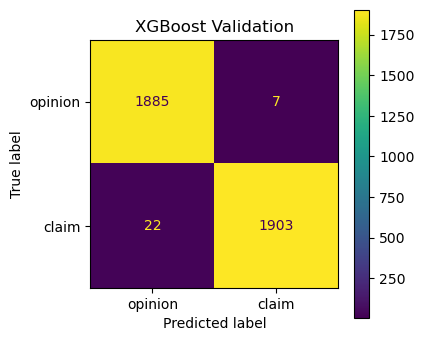

In [69]:
# Plot confusion matrix.
plot_confusion_matrix(y_val, xgb_val_preds, chart_title='XGBoost Validation')

**NOTE:**

The XGBoost model also performs very well on the validation data. The model predicted more false negatives than false positives, supporting the slightly lower recall score compared to the precision score.

#### Selecting the champion model

Compile results into one dataframe for easier side-by-side comparison.

In [70]:
# Concatenate results of random forest and XGBoost validation scores.
results = pd.concat([rf_val_results, xgb_val_results], axis=0)
results

,model,accuracy,precision,recall,f1
0,Random Forest Validation,0.997380,0.997403,0.997403,0.997403
0,XGBoost Validation,0.992402,0.996335,0.988571,0.992438


**NOTE:**

The random forest model performed slightly better in all scores. Therefore, the random forest model is selected as the champion model.

### Champion Model Evaluation

Evaluate champion model using test data to simulate real-world performance.

In [71]:
# Get predictions using test data.
rf_test_preds = rf_cv.predict(x_test_final)

In [72]:
# Get test scores of the model on test data.
rf_test_results = get_test_scores('Random Forest Test', y_test, rf_test_preds)
rf_test_results

,model,accuracy,precision,recall,f1
0,Random Forest Test,0.99869,0.998941,0.998412,0.998676


Append test results to `results` dataframe for easier side-by-side comparison with validation results.

In [73]:
# Concatenate validation and test results.
results = pd.concat([results, rf_test_results], axis=0)
results

,model,accuracy,precision,recall,f1
0,Random Forest Validation,0.997380,0.997403,0.997403,0.997403
0,XGBoost Validation,0.992402,0.996335,0.988571,0.992438
0,Random Forest Test,0.998690,0.998941,0.998412,0.998676


Plot the confusion matrix of test results.

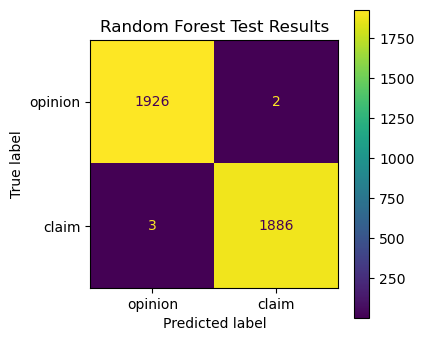

In [74]:
# Plot confusion matrix.
plot_confusion_matrix(y_test, rf_test_preds, chart_title='Random Forest Test Results')

**NOTE:**

The champion random forest model performed better on test data compared to validation data. It correctly identified 99.9% of the test data which is excellent. The model had three false negative predictions which is one more than the false positive predictions, in agreement with the slightly lower recall score compared to precision score.

#### Feature Importances

Cretate a plot to visualize the top 10 most important features in the model.

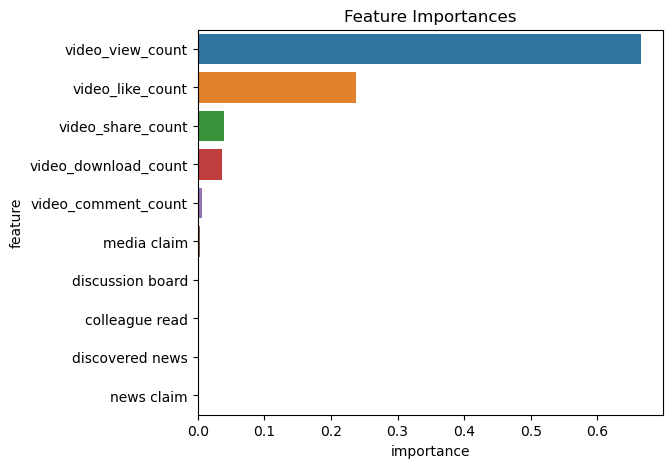

In [75]:
# Get importance values.
importances = rf_cv.best_estimator_.feature_importances_
features = x_test_final.columns

# Create feature importance DataFrame.
df_importances = pd.DataFrame({'feature': features, 'importance': importances})
# Get top 10 most important features
top_10_importances = df_importances.sort_values('importance', ascending=False).head(10)

# Create bar plot of the top 10 feature importances.
plt.figure(figsize=(6,5))
sns.barplot(top_10_importances, x='importance', y='feature', hue='feature', orient='horizontal')
plt.title('Feature Importances')
plt.show()

**NOTE:**

The top five most important features are video engagement attributes `video_view_count`, `video_like_count`, `video_share_count`, `video_download_count`, and `video_comment_count`. The next 5 important features are all related to engineered features from vectorizing `video_transcript_text`.

## Discussion
<a id='discussion'></a>

Exploratory data analysis in the earlier section implies that claim videos are more likely to violate terms of use policies; 
therefore, misidentifying claim videos have more negative impact on the business. The resulting champion model correctly predicted 
almost all entries in the test data. The model is observed to make more false negative predictions compared to false positives as 
observed in the confusion matrix and the slightly worse recall score vs. precision score. While this is result is less desirable in 
theory, the nearly perfect performance of the resulting champion model outweighs the mentioned potential drawback. Furthermore, the 
champion model performs better on all scores on test data compared to validation results, suggesting that the model does not overfit. 

Unsurprisingly, the top five most important features are video engagement attributes `video_view_count`, `video_like_count`, 
`video_share_count`, `video_download_count`, and `video_comment_count`. While the model does not provide any imformation on how these 
features relate to `claim_status`, earlier EDA showed that claim videos tend to have much higher video engagement. The next five most  
important features are all related to engineered features from vectorizing `video_transcript_text`. While they might have helped 
with the performance of the model, their feature importaces are much lower than the video engagement measures. With the very high 
performance scores achieved by the model on test data, the selected and engineered features from the current dataset is enough to 
accurately classify videos as having claims or opinions,

## Conclusion
<a id='conclusion'></a>

The model performs very well on test data, implying excellent real-world performance. The model is ready to be incorporated in the 
video review process as an automation tool for initial screening of reported videos. While the model accurqately recognizes patterns 
differentiating claim from opinion videos, it is recommended to periodically re-evaluate the real-world performance of the model as 
these patterns may change over time.

Finally, a recommended next step is to streamline the model development pipeline so that the model can be easily updated regularly 
with new data. This will enable the developed model to capture new trends that may emerge over time.

## Appendix
<a id='appendix'></a>

### Create charts for publication

Create plots comparing video engagement attributes between claim and opinion videos.

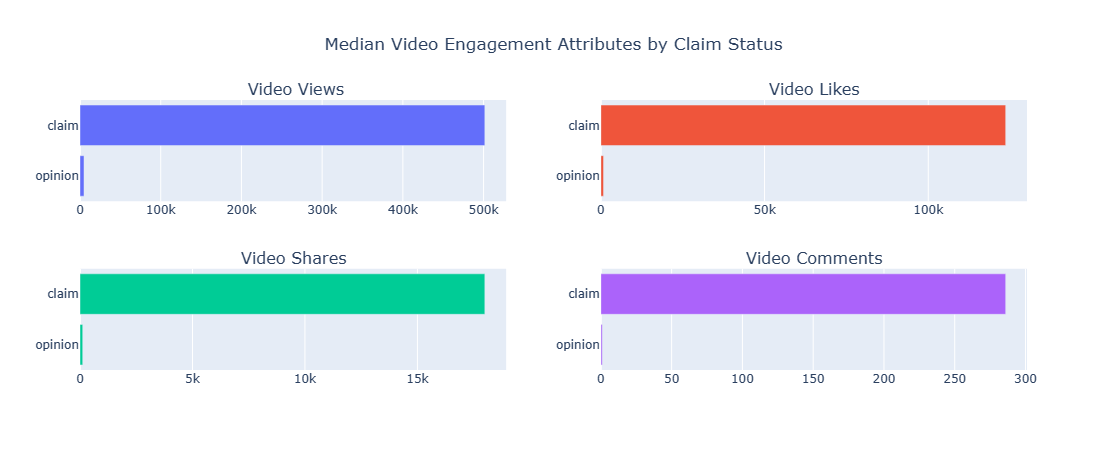

In [80]:
# Sort values of `claim_status` in DataFrame by reversed alphabetical order
engagement_by_claim.sort_values('claim_status', ascending=False, inplace=True)

# Create 2x2 subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=(' Video Views', 'Video Likes', 'Video Shares', 'Video Comments'))

# Create bar plot for `video_view_count`.
fig.add_trace(go.Bar(x=engagement_by_claim['video_view_count'], 
                     y=engagement_by_claim['claim_status'],
                     orientation='h'), 
              row=1, col=1
             )

# Create bar plot for `video_like_count`.
fig.add_trace(go.Bar(x=engagement_by_claim['video_like_count'], 
                     y=engagement_by_claim['claim_status'], 
                     orientation='h'), 
              row=1, col=2
             )

# Create bar plot for `video_share_count`.
fig.add_trace(go.Bar(x=engagement_by_claim['video_share_count'], 
                     y=engagement_by_claim['claim_status'], 
                     orientation='h'), 
              row=2, col=1
             )

# Create bar plot for `video_comment_count`.
fig.add_trace(go.Bar(x=engagement_by_claim['video_comment_count'], 
                     y=engagement_by_claim['claim_status'], 
                     orientation='h'), 
              row=2, col=2
             )

# Set chart title and other properties.
fig.update_layout(title_text='Median Video Engagement Attributes by Claim Status', 
                  title_x=0.5,
                  height=450, 
                  width=800, 
                  showlegend=False
                 )

fig.show()

Create histogram of `verified_status` by `claim_status`.

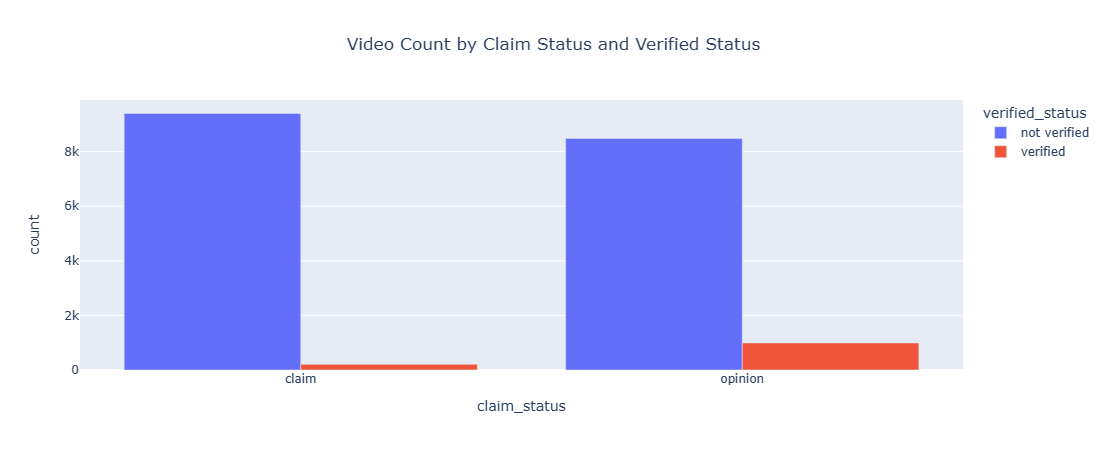

In [77]:
# Get value counts of `verified_status` grouped by `claim_status`.
by_claim_verified = data.groupby('claim_status')['verified_status'].value_counts().reset_index()

# Create bar chart.
fig = px.bar(by_claim_verified, 
       x='claim_status', 
       y='count', 
       color='verified_status', 
       barmode='group', 
       width=800, 
       height=450, 
       title='Video Count by Claim Status and Verified Status'
      )

# Align title to center.
fig.update_layout(title_x=0.5)

fig.show()

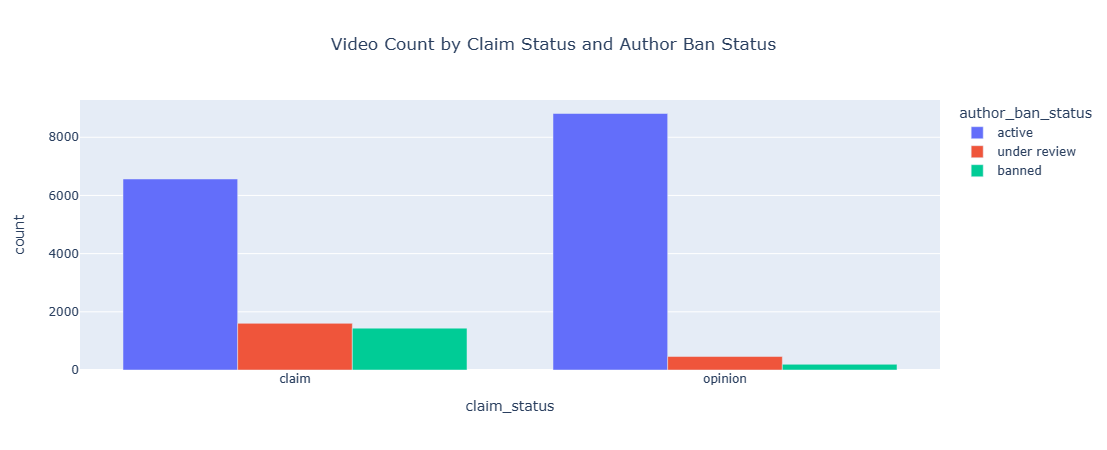

In [81]:
# Create histogram of `author_ban_status` by `claim_status`.

# Get value counts of `author_ban_status` grouped by `claim_status`.
by_claim_author_ban = data.groupby('claim_status')['author_ban_status'].value_counts().reset_index()

# Create bar chart
fig = px.bar(by_claim_author_ban, 
       x='claim_status', 
       y='count', 
       color='author_ban_status', 
       barmode='group', 
       width=800, 
       height=450, 
       title='Video Count by Claim Status and Author Ban Status'
      )

# Align title to center.
fig.update_layout(title_x=0.5)

fig.show()

Create feature importance bar chart.

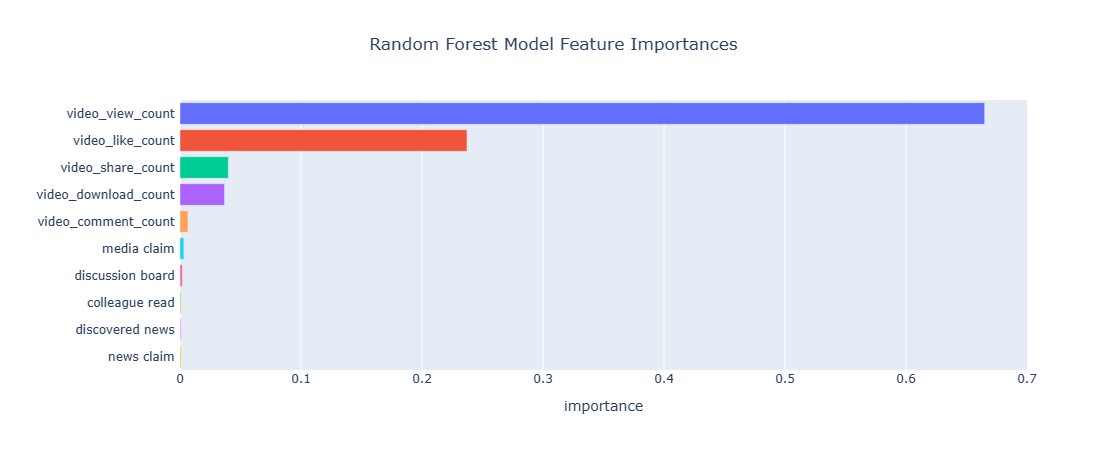

In [79]:
# Create bar chart.
fig = px.bar(top_10_importances, 
             x='importance', 
             y='feature', 
             color='feature', 
             orientation='h',
             labels={'feature': ''},
             width=800,
             height=450,
             title='Random Forest Model Feature Importances'
            )

# Set chart properties.
fig.update_layout(yaxis=dict(ticksuffix=' '), 
                  title_x=0.5,
                  showlegend=False
                 )

fig.show()